In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt;
from tensorflow.python.keras.optimizer_v2.adam import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from hypopt import GridSearch
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')


In [3]:
train = [os.path.join("Data/training/",img) for img in os.listdir("Data/training/")]
val = [os.path.join("Data/validation/",img) for img in os.listdir("Data/validation/")]
test = [os.path.join("Data/evaluation/",img) for img in os.listdir("Data/evaluation/")]

len(train),len(val),len(test)


(386, 81, 64)

In [4]:
train[0:5]

['Data/training/0_11.jpeg',
 'Data/training/0_108.jpeg',
 'Data/training/1_108.jpeg',
 'Data/training/0_46.jpeg',
 'Data/training/1_84.jpeg']

In [5]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 11
 
# Convert class labels in one hot encoded vector
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

train_y[0:2]


[0, 0]

In [6]:
y_train[0:2]


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Training data available in 2 classes
[186, 200]


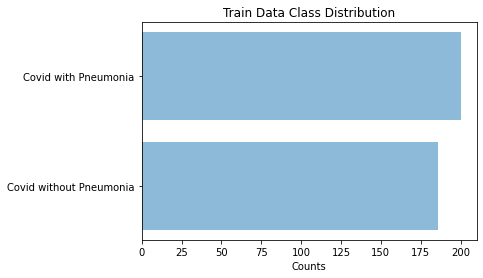

In [7]:
print("Training data available in 2 classes")
print([train_y.count(i) for i in range(0,2)])

food_classes = ('Covid without Pneumonia','Covid with Pneumonia')

y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,2)]

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')

plt.show()



In [8]:

print("Validation data available in 2 classes")
[val_y.count(i) for i in range(0,2)]

Validation data available in 2 classes


[38, 43]

In [9]:
print("Test data available in 2 classes")
[test_y.count(i) for i in range(0,2)]

Test data available in 2 classes


[18, 46]

In [10]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

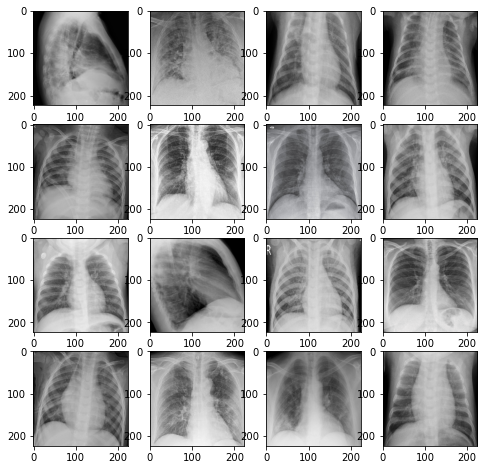

In [11]:
show_imgs(train)

In [12]:
def create_features(dataset):
    
    x_scratch = []

    # loop over the images
    for imagePath in dataset:

        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        # add the image to the batch
        x_scratch.append(image)
        
    x = np.vstack(x_scratch)
    return x


In [13]:
train_x = create_features(train)
val_x = create_features(val)
test_x = create_features(test)

In [14]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(386, 224, 224, 3)
(81, 224, 224, 3)
(64, 224, 224, 3)


In [15]:
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5', verbose=1,save_best_only=True)

In [16]:
print("[INFO loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()


[INFO loading network...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 

In [17]:
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(100, activation='relu'))
model_transfer_full.add(Dense(11, activation='softmax'))
model_transfer_full.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 14,767,099
Non-trainable params: 0
_________________________________________________________________


In [18]:

opt = Adam(lr=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_full.fit(train_x, y_train, batch_size=32, epochs=10, validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/10
13/13 [==============================] - 271s 20s/step - loss: 2.3748 - accuracy: 0.4299 - val_loss: 0.3538 - val_accuracy: 0.8395

Epoch 00001: val_loss improved from inf to 0.35379, saving model to scratchmodel.best.hdf5
Epoch 2/10
13/13 [==============================] - 277s 21s/step - loss: 0.3859 - accuracy: 0.8789 - val_loss: 0.1362 - val_accuracy: 0.9506

Epoch 00002: val_loss improved from 0.35379 to 0.13621, saving model to scratchmodel.best.hdf5
Epoch 3/10
13/13 [==============================] - 281s 22s/step - loss: 0.1953 - accuracy: 0.9380 - val_loss: 0.0678 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.13621 to 0.06784, saving model to scratchmodel.best.hdf5
Epoch 4/10
13/13 [==============================] - 258s 20s/step - loss: 0.2053 - accuracy: 0.9542 - val_loss: 0.0469 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.06784 to 0.04686, saving model to scratchmodel.best.hdf5
Epoch 5/10
13/13 [==============================] - 

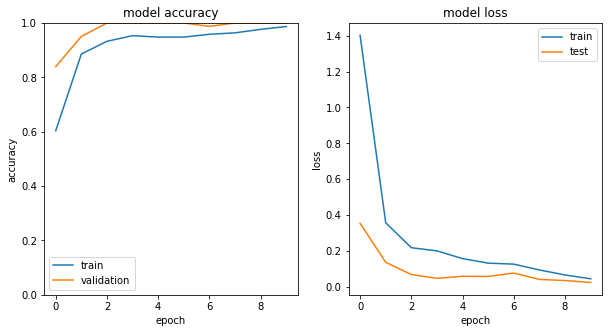

In [19]:
def plot_accuracy_loss(history):    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.ylim([0, 1])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_accuracy_loss(history)

In [20]:
preds = np.argmax(model_transfer_full.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,2))


Accuracy on Test Data:  0.96875

Number of correctly identified imgaes:  62 



array([[17,  1],
       [ 1, 45]])